# Multi-agent CartPole solver using multi-agent policy gradient (MAPG) with a shared hybrid quantum policy.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow.keras as keras
import tensorflow as tf

2024-01-28 12:21:17.163772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [4]:
import numpy as np

state_bounds = tf.convert_to_tensor(np.array([2.4, 2.5, 0.21, 2.5], dtype='float32'))

def generate_model_actor_classical(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Lambda(lambda x: x/state_bounds)] # Normalizes input states.]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model


def generate_model_critic_classical(units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Lambda(lambda x: x/state_bounds)] # Normalizes input states.]
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [5]:
n_actions = 2
n_agents = 2

In [6]:
# Quantum actor.
n_layers = 5
model_policy = eqmarl.models.generate_model_CartPole_actor_quantum(
    n_layers=n_layers,
    name='policy-quantum-shared',
    )


# optimizer_actor = keras.optimizers.Adam(learning_rate=0.1)
optimizer_policy = [
    tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
]

model_policy.build((None, 4))
model_policy.summary()

Model: "policy-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 1)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 2)                92        
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 2)                2         
 ial)                                                            
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


## Training

In [7]:
gamma = 0.99
env = gym.vector.make('CartPole-v1', num_envs=n_agents)

algo = eqmarl.algorithms.MAPG(
    env=env,
    model_policy=model_policy,
    optimizer_policy=optimizer_policy,
    gamma=gamma,
    )

reward_history, metrics_history = algo.train(n_episodes=1000, max_steps_per_episode=500)

Training for 1000 episodes, press 'Ctrl+C' to terminate early


Episode 404:  40%|████      | 404/1000 [09:45<14:24,  1.45s/episode, episode_reward=[500. 500.]]  

Terminating early at episode 404


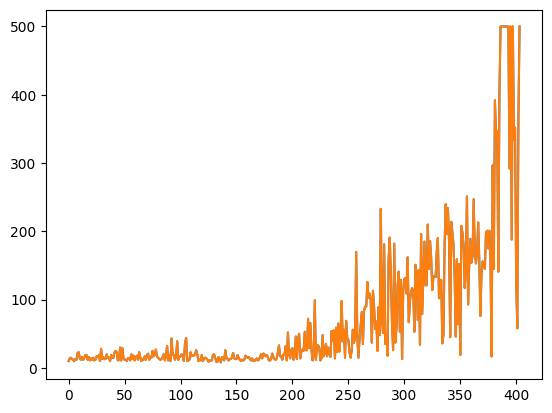

In [8]:
plt.plot(reward_history)